In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats("svg")
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

C:\Users\Admin\AppData\Local\Temp\ipykernel_14032\2058423583.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats("svg")


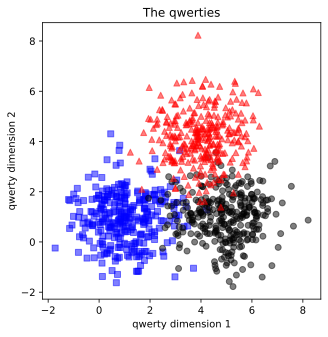

In [3]:
# create data

nPerClust = 300
blur = 1

A = [ 1, 1 ]
B = [ 5, 1 ]
C = [ 4, 4 ]

# generate data
a = [ A[0] + np.random.randn(nPerClust)*blur, A[1] + np.random.randn(nPerClust)*blur]
b = [ B[0] + np.random.randn(nPerClust)*blur, B[1] + np.random.randn(nPerClust)*blur]
c = [ C[0] + np.random.randn(nPerClust)*blur, C[1] + np.random.randn(nPerClust)*blur]


# true labels
labels_np = np.hstack((np.zeros((nPerClust)), np.ones((nPerClust)), 1 + np.ones((nPerClust))))

# concatenate into a matrix
data_np = np.hstack((a, b, c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long()

# show the data
fig = plt.figure(figsize = (5, 5))
plt.plot(data[np.where(labels == 0)[0], 0], data[np.where(labels == 0)[0], 1], "bs", alpha = .5)
plt.plot(data[np.where(labels == 1)[0], 0], data[np.where(labels == 1)[0], 1], "ko", alpha = .5)
plt.plot(data[np.where(labels == 2)[0], 0], data[np.where(labels == 2)[0], 1], "r^", alpha = .5)
plt.title("The qwerties")
plt.xlabel("qwerty dimension 1")
plt.ylabel("qwerty dimension 2")
plt.show()

In [6]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = 0.11)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# finally, translate into dataloader objects
batchsize = 16
train_loader = DataLoader(train_data, batch_size = batchsize, shuffle = True, drop_last = True)
test_loader = DataLoader(test_data, batch_size = test_data.tensors[0].shape[0])

In [7]:
# how many batches are there?
print(f"There are {len(train_loader)} batches, each with {batchsize} samples.")

There are 50 batches, each with 16 samples.


In [8]:
# create a class for the model
def createTheQwertyNet():
    class qwertyNet(nn.Module):
        def __init__(self):
            super().__init__()

            # input layer
            self.input = nn.Linear(2, 8)

            # hidden layer
            self.fc1 = nn.Linear(8, 8)

            # output layer
            self.output = nn.Linear(8, 3)

        # forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            return self.output(x)

    # create the model instance
    net = qwertyNet()

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr = .01)

    return net, lossfun, optimizer

In [9]:
# test the model with fake input
net, lossf, opt = createTheQwertyNet()
print(net)

# input is ten samples
input = torch.rand(10, 2)
net(input)

qwertyNet(
  (input): Linear(in_features=2, out_features=8, bias=True)
  (fc1): Linear(in_features=8, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=3, bias=True)
)


tensor([[ 0.0455, -0.1121,  0.0667],
        [ 0.0420, -0.1107,  0.0624],
        [ 0.0441, -0.1114,  0.0651],
        [ 0.0314, -0.1033,  0.0512],
        [ 0.0468, -0.1124,  0.0684],
        [ 0.0291, -0.1001,  0.0490],
        [ 0.0409, -0.1103,  0.0610],
        [ 0.0405, -0.1103,  0.0603],
        [ 0.0303, -0.1009,  0.0500],
        [ 0.0416, -0.1107,  0.0617]], grad_fn=<AddmmBackward0>)

In [13]:
 # train the model

def trainTheModel():

    # training parameter
    numepochs = 1000

    # create a new model
    net, lossfun, optimizer = createTheQwertyNet()
    
    trainAcc = []
    testAcc = []
    losses = torch.zeros(numepochs)
    
    # train the model
    for epochi in range(numepochs):

        # activate training mode
        net.train()
        
        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)
            
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute training accuracy for this batch
            matches = torch.argmax(yHat, axis = 1) == y # booleans (false/true); selects the class with the highest predicted probability for each input.
            # The == operator compares the predicted class to the actual class, returning a Boolean tensor (True for correct predictions, False for incorrect).
            matchesNumeric = matches.float() # convert to numbers (0/1)
            accuracyPct = 100*torch.mean(matchesNumeric) # avg and * by 100
            batchAcc.append(accuracyPct)
            
        # now that we've trained through the batches, get avg training accuracy
        trainAcc.append(np.mean(batchAcc))

        # get avg losses over the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        net.eval() # activate testing mode
        X, y = next(iter(test_loader))  # extract X, y from test dataloader
        with torch.no_grad(): # deactivates auto grad
            yHat = net(X)

        # compute test accuracy
        testAcc.append(100 * torch.mean((torch.argmax(yHat, axis = 1) == y).float()))
        
    # function output
    return trainAcc, testAcc, losses, net

In [14]:
trainAcc, testAcc, losses, net = trainTheModel()

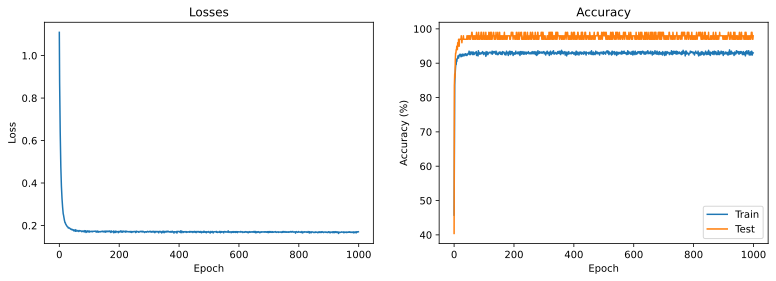

In [15]:
fig, ax = plt.subplots(1, 2, figsize = (13, 4))

ax[0].plot(losses.detach())
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Losses")

ax[1].plot(trainAcc, label = "Train")
ax[1].plot(testAcc, label = "Test")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Accuracy")
ax[1].legend()
plt.show()

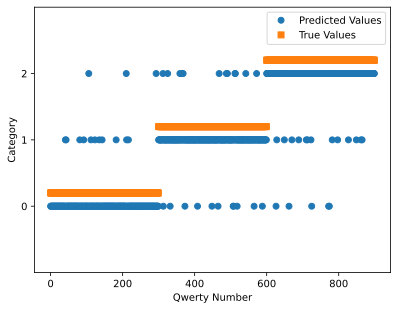

In [16]:
# run the data thru the model to get the categorical predictions
yHat = net(data)
predictions = torch.argmax(yHat, axis = 1)

# plot those against the real data
plt.plot(predictions, "o", label = "Predicted Values")
plt.plot(labels+.2, "s", label = "True Values")
plt.xlabel("Qwerty Number")
plt.ylabel("Category")
plt.yticks([0, 1, 2])
plt.ylim([-1, 3])
plt.legend()
plt.show()

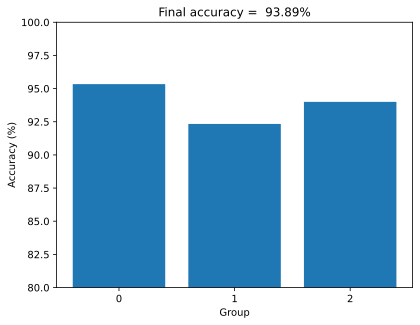

In [17]:
# recode each predictions by accuracy
accuracy = (predictions == labels).float()

# compute overall accuracy
totalAcc = torch.mean(100 * accuracy).item()

# and avg by group
accuracyByGroup = np.zeros(3)
for i in range(3):
    accuracyByGroup[i] = 100 * torch.mean(accuracy[labels == i])

plt.bar(range(3), accuracyByGroup)
plt.ylim([80, 100])
plt.xticks([0, 1, 2])
plt.xlabel("Group")
plt.ylabel("Accuracy (%)")
plt.title(f"Final accuracy = {totalAcc: .2f}%")
plt.show()